In [21]:
!pip install -q numpy pandas geopandas rasterio shapely matplotlib opencv-python-headless opencv-contrib-python-headless tensorflow scikit-learn joblib tqdm

Reading image satellite_1.jp2
Reading image satellite_4.jp2



Reading tiles (satellite_1.jp2): 100%|██████████| 225/225 [00:00<00:00, 168220.75tile/s]


Image satellite_1.jp2 split into 225 tiles.



Reading tiles (satellite_4.jp2): 100%|██████████| 225/225 [00:00<00:00, 251122.51tile/s]


Image satellite_4.jp2 split into 225 tiles.



Detecting keypoints (satellite_4.jp2): 100%|██████████| 225/225 [01:00<00:00,  3.72tile/s]



Preparing descriptors for matching...
Matching keypoints...

Found 19077 matches before filtering
Filtered to top 400 matches

Matched image saved as satellite_matched_image.jpg


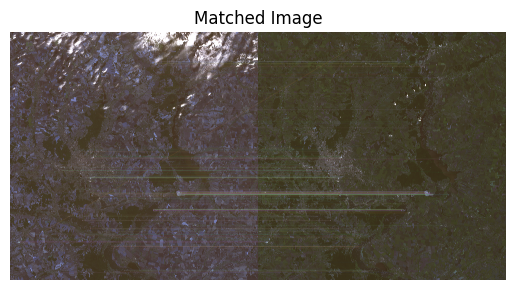

In [23]:
import os
import cv2
import warnings
import rasterio
import numpy as np
from tqdm import tqdm
from typing import List, Dict
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=rasterio.errors.NotGeoreferencedWarning)


def read_large_image_tiles(image_path: str, tile_size: int = 1024, overlap: int = 256) -> List[Dict]:
    """
        Splits a large image into smaller overlapping tiles for efficient processing.

        Args:
            image_path (str): Path to the input image.
            tile_size (int): Size of each tile in pixels.
            overlap (int): Overlap size between neighboring tiles.

        Returns:
            List[Dict]: A list of dictionaries, each containing a tile and its coordinates.
    """

    with rasterio.open(image_path) as src:
        image = src.read()

        if len(image.shape) == 3:
            image = np.transpose(image, (1, 2, 0))
        else:
            image = image[0]

        image = (image / image.max() * 255).astype(np.uint8)
        tiles = []
        height, width = image.shape[:2]

        total_tiles = ((height - 1) // (tile_size - overlap) + 1) * ((width - 1) // (tile_size - overlap) + 1)

        pbar = tqdm(total=total_tiles, desc=f"Reading tiles ({os.path.basename(image_path)})", unit="tile")

        for y in range(0, height, tile_size - overlap):
            for x in range(0, width, tile_size - overlap):
                tile = image[y:y + tile_size, x:x + tile_size]

                if tile.size > 0 and tile.shape[0] > 10 and tile.shape[1] > 10:
                    tiles.append({
                        'tile': tile,
                        'x': x,
                        'y': y
                    })
                pbar.update(1)

        pbar.close()
        print(f"Image {os.path.basename(image_path)} split into {len(tiles)} tiles.\n")
        return tiles


def detect_keypoints_tiles(tiles: List[dict], image_path: str, method: str = 'sift') -> List[dict]:
    """
        Detects keypoints and their descriptors for each image tile.

        Args:
            tiles (List[dict]): List of image tiles.
            image_path (str): Path to the input image.
            method (str): Keypoint detection method ('sift' or 'orb').

        Returns:
            List[dict]: List of dictionaries containing keypoints and descriptors for each tile.
    """
    detector = cv2.SIFT_create() if method == 'sift' else cv2.ORB_create()

    keypoint_tiles = []
    for tile_data in tqdm(tiles, desc=f"Detecting keypoints ({os.path.basename(image_path)})", unit="tile"):
        gray = cv2.cvtColor(tile_data['tile'], cv2.COLOR_BGR2GRAY) if len(tile_data['tile'].shape) == 3 else tile_data[
            'tile']
        kp, desc = detector.detectAndCompute(gray, None)

        adjusted_kp = []
        for k in kp:
            adjusted_kp.append(
                cv2.KeyPoint(
                    k.pt[0] + tile_data['x'],
                    k.pt[1] + tile_data['y'],
                    k.size,
                    k.angle,
                    k.response,
                    k.octave,
                    k.class_id
                )
            )

        keypoint_tiles.append({
            'keypoints': adjusted_kp,
            'descriptors': desc,
            'x': tile_data['x'],
            'y': tile_data['y']
        })

    return keypoint_tiles


def match_global_keypoints(keypoint_tiles1: List[dict], keypoint_tiles2: List[dict], max_matches: int = 1000) -> List:
    """
    Matches keypoints between two images.

    Args:
        keypoint_tiles1 (List[dict]): Keypoints from the first image.
        keypoint_tiles2 (List[dict]): Keypoints from the second image.
        max_matches (int): Maximum number of matches to return.

    Returns:
        List: List of best matches between keypoints.
    """

    print("\nPreparing descriptors for matching...")
    all_desc1 = np.vstack([tile['descriptors'] for tile in keypoint_tiles1 if tile['descriptors'] is not None])
    all_desc2 = np.vstack([tile['descriptors'] for tile in keypoint_tiles2 if tile['descriptors'] is not None])

    print("Matching keypoints...\n")
    matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = matcher.match(all_desc1, all_desc2)

    print(f"Found {len(matches)} matches before filtering")
    print(f"Filtered to top {max_matches} matches")

    filtered_matches = sorted(matches, key=lambda x: x.distance)[:max_matches]

    return filtered_matches


def visualize_matches(image1: np.ndarray, image2: np.ndarray,
                      keypoints1: List[cv2.KeyPoint],
                      keypoints2: List[cv2.KeyPoint],
                      matches: List) -> np.ndarray:
    """
    Visualizes the matches between two images.

    Args:
        image1 (np.ndarray): First image.
        image2 (np.ndarray): Second image.
        keypoints1 (List[cv2.KeyPoint]): Keypoints of the first image.
        keypoints2 (List[cv2.KeyPoint]): Keypoints of the second image.
        matches (List): List of matches between keypoints.

    Returns:
        np.ndarray: Image with visualized matches.
    """

    return cv2.drawMatches(
        image1, keypoints1,
        image2, keypoints2,
        matches, None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )


def process_images(image1_path: str, image2_path: str, method: str = 'sift', max_matches: int = 1000) -> Dict:
    """
    Executes the full image pair processing pipeline: tiling, keypoint detection, and matching.

    Args:
        image1_path (str): Path to the first image.
        image2_path (str): Path to the second image.
        method (str): Keypoint detection method.
        max_matches (int): Maximum number of matches.

    Returns:
        Dict: Dictionary with the processing results (matches and keypoints).
    """

    tiles1 = read_large_image_tiles(image1_path)
    tiles2 = read_large_image_tiles(image2_path)

    keypoint_tiles1 = detect_keypoints_tiles(tiles1, image1_path, method)
    keypoint_tiles2 = detect_keypoints_tiles(tiles2, image2_path, method)

    matches = match_global_keypoints(keypoint_tiles1, keypoint_tiles2, max_matches)

    return {
        'matches': matches,
        'keypoint_tiles1': keypoint_tiles1,
        'keypoint_tiles2': keypoint_tiles2
    }


def read_image(image_path: str) -> np.ndarray:
    with rasterio.open(image_path) as src:
        image = src.read()
        image = np.transpose(image, (1, 2, 0))
        return (image / image.max() * 255).astype(np.uint8)


def main():
    image1_path = 'satellite_1.jp2'
    image2_path = 'satellite_4.jp2'

    output_filename = 'satellite_matched_image.jpg'

    max_matches = 400

    print(f"Reading image {image1_path}")
    image1 = read_image(image1_path)
    print(f"Reading image {image2_path}\n")
    image2 = read_image(image2_path)

    results = process_images(image1_path, image2_path, max_matches=max_matches)

    global_kp1 = [kp for tile in results['keypoint_tiles1'] for kp in tile['keypoints']]
    global_kp2 = [kp for tile in results['keypoint_tiles2'] for kp in tile['keypoints']]

    matched_image = visualize_matches(
        image1, image2,
        global_kp1, global_kp2,
        results['matches']
    )

    cv2.imwrite(output_filename, matched_image)
    print(f"\nMatched image saved as {output_filename}")

    plt.imshow(cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB))
    plt.title('Matched Image')
    plt.axis('off')
    plt.show()


if __name__ == '__main__':
    main()
